## Goal
Use Truncated SVD to create word vectors on Amazon Food reviews
1. Using TFIDF pick top 2000 words from amazon food reviews dataset.
2. Compute co-occurence matrix for the 2000 words, where given a word,w_i, - the cell w_ij contains the # of times w_j occurs in the context of word, w_i - take a neighborhood of size 5. The co-occurence matrix will be 2000x2000.
3. Decompose it into X = U sigma V_T, where X is nxn, U is nxn, sigma is nxn and V_T is nxn
4. Do TruncatedSVD and get U_hat sigma-hat V_T_hat where U_hat is nxk, sigma is kxk, V_T_hat is kxn. Try with multiple values of K and see what happens or find the correct K using the amount of variance explained. This is similar to PCA. In PCA we used eigen values, in SVD we use the singular values.
Each row is u_hat corresponds to one word, which is the word vector for that word, w_i.
5. Cluster the word vectors for the top n_words (top 2000 words). Use KMeans with K=50. The important thing here is words in a cluster should semantically be related. For instance, if there is a word Indian, then you should get things such as roti, spice
6. Repeat the above steps for top 5000 and 10000 words

### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

Google Word2Vec (GoogleNews-vectors-negative300.bin) is also used and those are available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy import spatial
pd.options.display.max_colwidth = 20000
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud, STOPWORDS
from itertools import islice

from sklearn.decomposition import TruncatedSVD
                                         

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

import itertools, pickle, random, sqlite3, nltk, string, re, operator, math
from pathlib import Path
from scipy import sparse
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from datetime import datetime, timedelta

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Run Classifier

In [2]:
def plot_word_cloud(file_name, title, word_cloud_column):
    if not file_name or not title or not word_cloud_column:
        print ('file_name, title and word_cloud_column are mandatory parameters')
        return
    
    df = pd.read_csv(file_name, encoding ="latin-1") 

    comment_words = ' '
    stopwords = set(STOPWORDS) 

    for i in range(df.ClusterID.nunique()):
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(str(df[df.ClusterID == i][word_cloud_column])) 

        # plot the WordCloud image                        
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.title(title + ' ' + str(i))
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 

        plt.show() 

In [3]:
def plot_elbow(K, sse):
    # Plot the elbow
    plt.plot(K, sse, 'bx-')
    
    plt.xlabel('k')
    plt.ylabel('Sum of distances of samples to their closest cluster center')

    plt.title('The Elbow Method showing the optimal k')
    plt.grid()
    
    plt.show()

In [4]:
def run_kmeans(X, Ks):
    sse = []
    
    for k in Ks:
        model = KMeans(n_clusters=k, n_jobs=-1).fit(X)
        sse.append(model.inertia_)
            
    plot_elbow(Ks, sse)
#     return X

In [5]:
def run_SVD(matrix, n_components):
    for n_component in n_components:
        print ('Fitting model with {} components'.format(n_component))
        model = TruncatedSVD(n_components=n_component)
        red_matrix = model.fit_transform(matrix)
#         print('Explained Variance Ratio is {}'.format(model.explained_variance_ratio_))
        print('Sum of explained variance ratio is {}'.format(model.explained_variance_ratio_.sum()))
        print('Singular values are {}'.format(model.singular_values_))
        print ('-'*80)
    return red_matrix

## Bag of Words

In [6]:
def get_bow_tfidfdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    print ('Positive count is {}'.format(pos_limit))
#     pos_qry = "SELECT Text, BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_qry = "SELECT BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT BowTfIDFText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))
    return data

In [7]:
#find sentences that contain the words
def find_sentences(ds, words):
    
    # contains index of the sentences that contains the top n words
    indices = set()
    
    for word in words:
        c = ds.contains(word, regex=False)
        for i, word in enumerate(c.iteritems()):
            #if the word is present in a sentence add its index to 'd'
            if word:
                indices.add(i)

    return indices

In [8]:
def find_neighbors(sentence, from_word, k):
#     print ('Finding neighbors for {} in sentence \n{}'.format(from_word, sentence))
    neighbors = list()
    
    #get all occurrences of the word
    indices = [i for i, x in enumerate(sentence.split()) if x == from_word]
#     print ('Word {} occurs in {}'.format(from_word, indices))
    
    #find all the k neighbors on either side of the word
    for i in indices:
        #'neighbors' will contain all the 'k' words around it, including itself
        neighbors = list(islice(sentence.split(), max(i-k, 0), i+1+k))
#         print ('Neighbors occuring around {} is {}'.format(sentence.split()[i], neighbors))
        #remove all occurrences of the 'word' from the neighborhood list
        neighbors = list(filter(lambda a: a != from_word, neighbors))
#         print ('Neighbors occuring around {} is {}'.format(sentence.split()[i], neighbors))
#         neighbors.remove(from_word)
    return neighbors

In [9]:
def get_co_occurrence(sentence, top_n_words, k, co_occur_matrix):

    for word in top_n_words:
        #find 'k' neighbors for the 'word'
        neighbors = find_neighbors(sentence, word, k)
        
        #neigbors contains all the 'k' words around 'word' but we are interested to only if any of the top_n_words occur
        #in the neighborhood
        neighbors = set(top_n_words).intersection(neighbors)
        #find the index of these 'neighbors' and update the co-occurrence-matrix
        for n_w in neighbors:
            co_occur_matrix[top_n_words.index(word), top_n_words.index(n_w)]+=1
#             print ('Cooccurrence matrix after updating for {} and {} is \n{}'.format(word, n_w, co_occur_matrix))
    return co_occur_matrix

In [10]:
def get_top_n_similarity(word, top_n_words, reduced_co_occur_matrix, n):
    sim_dict = dict()
    
    #index of the 'word'
    word_index = top_n_words.index(word)
    #vector representing the 'word'
    word_vector = reduced_co_occur_matrix[word_index]
    
    #loop through all the words in the co_occur_matrix and find out similarity between 'word' and other words
    for i in range(len(reduced_co_occur_matrix)):
        
        #do not find similarity between the 'word' and itself
        if i == word_index:
            continue
        
        other_word_vector = reduced_co_occur_matrix[i]
        
        # cosine computes the distance, and not the similarity. So, subtract the value from 1 to get the similarity.
        sim = 1 - spatial.distance.cosine(word_vector, other_word_vector)

        if not math.isnan(sim) and sim != 0.0:
            sim_dict[top_n_words[i]] = sim
    
    sorted_sim_dict = sorted(sim_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_sim_dict[0:n]

In [11]:
def group_words_clusters(top_words_with_clusters):
    cluster = dict()
    for k, v in top_words_with_clusters.items():
        if v in cluster:
            existing_value = cluster[v]
            existing_value.append(k)
            cluster[v] = existing_value
        else:
            cluster[v] = [k]
    return sorted(cluster.items(), key=operator.itemgetter(0))

## TF-IDF

In [13]:
def vectorize_tfidf(X, top_n):
    #Vectorize the reviews
    tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2), max_features=30000, min_df = 0.0009)
#     tf_idf_vect = TfidfVectorizer()
        
    #Build vocabulary from X_train
    X_counts = tf_idf_vect.fit_transform(X['BowTfIDFText'].values)
        
    print("Shape of vectorized dataset is {}".format(X_counts.get_shape()))
    print("Number of unique words in the dataset is ", X_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_counts))
    
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized Bag of Words review contains {} with {} features each'.format(*X_std_data.shape))
    
    feature_array = np.array(tf_idf_vect.get_feature_names())
    tfidf_sorting = np.argsort(X_std_data.toarray()).flatten()[::-1]

    top_n_words = list(feature_array[tfidf_sorting][:top_n])
    
    return X_std_data, top_n_words, tf_idf_vect

### Find tfIDF vectors and retrieve top_n_words (2000)

In [15]:
no_of_records=50000
top_n = 2000

print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
X, top_n_words, tf_idf_vect = vectorize_tfidf(data, top_n)
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

15:14:27
Positive count is 25000
Positive reviews shape is (25000, 2)
Negative reviews shape is (25000, 2)
Both positive and negative reviews combined together contains 50000 reviews
Shape of vectorized dataset is (50000, 5820)
Number of unique words in the dataset is  5820
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 50000 with 5820 features each
15:15:33


### Create co-occurrence matrix for the top_n_words and run SVD

In [17]:
#nearest neighbors to search for context
k = 5
#reduce svd components to
n_components = [6, 10, 15, 20]

n = len(top_n_words)
co_occur_matrix = np.zeros([n, n])

#find sentences that contain top_n_words
print ('Finding sentences that contain top_n_words.......')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))
sent_indices = find_sentences(data.BowTfIDFText.str, top_n_words)

#go through each sentence and build a co-occurrence matrix
print ('Going through each sentence to build a co-occurrence matrix........')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))
for sent_index in sent_indices:
    co_occur_matrix = get_co_occurrence(data.BowTfIDFText[sent_index], top_n_words, k, co_occur_matrix)

#run SVD on co-occurrence-matrix
print ('Running SVD with {} components........'.format(n_components))
ist = datetime.now()
print (format(ist, '%H:%M:%S'))
reduced_co_occur_matrix = run_SVD(co_occur_matrix, n_components)

Finding sentences that contain top_n_words.......
15:16:38
Going through each sentence to build a co-occurrence matrix........
15:17:32
Running SVD with [6, 10, 15, 20] components........
17:09:50
Fitting model with 6 components
Sum of explained variance ratio is 0.8607557610598783
Singular values are [8869.70781248 1806.1546129  1567.68567763 1296.77213365 1178.0384614
 1138.49434479]
--------------------------------------------------------------------------------
Fitting model with 10 components
Sum of explained variance ratio is 0.8988111955754747
Singular values are [8869.70781248 1806.15461295 1567.68567775 1296.77219093 1178.03856688
 1138.49442404 1113.66806039  985.04763693  904.74135056  773.67777044]
--------------------------------------------------------------------------------
Fitting model with 15 components
Sum of explained variance ratio is 0.9239378432244681
Singular values are [8869.70781248 1806.15461295 1567.68567776 1296.77219145 1178.03856974
 1138.49442746 1113.6

In [18]:
#run SVD with a reasonable number of components
reduced_co_occur_matrix = run_SVD(co_occur_matrix, [15])

Fitting model with 15 components
Sum of explained variance ratio is 0.9239362611133387
Singular values are [8869.70781248 1806.15461295 1567.68567776 1296.77219141 1178.03856872
 1138.49442873 1113.66807132  985.04767864  904.74201445  773.68080016
  753.0145799   732.45119288  709.4551456   652.65758303  602.34901444]
--------------------------------------------------------------------------------


### Run KMeans with k values on the co-occurrence matrix containing max explained variance ratio

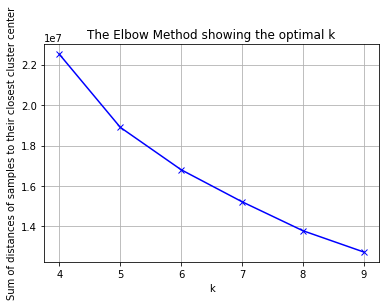

In [19]:
run_kmeans(reduced_co_occur_matrix, range(4, 10))

### Using the optimal_k from above run KMeans and group words and clusters

In [20]:
optimal_k = 6

model = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(reduced_co_occur_matrix)
#create a dictionary with top_n_words and its cluster
top_words_with_clusters = dict(zip(top_n_words, model.labels_))
print (group_words_clusters(top_words_with_clusters))

[(0, ['zuke mini', 'forward tri', 'foul', 'found amazon', 'found local', 'found one', 'found product', 'found tea', 'fortun', 'four star', 'fourth', 'fragil', 'fragranc', 'fragrant', 'franc', 'frank', 'freak', 'forward', 'formul', 'foot', 'food tast', 'food treat', 'food tri', 'food use', 'food well', 'food would', 'food year', 'fool', 'forc', 'free product', 'foreign', 'forev', 'forget', 'forgot', 'forgotten', 'fork', 'form', 'former', 'free food', 'free ship', 'food sinc', 'frost', 'fructos', 'fructos corn', 'fruit flavor', 'fruiti', 'frustrat', 'fudg', 'fulfil', 'full bodi', 'full flavor', 'full refund', 'fulli', 'fun', 'function', 'funki', 'funni', 'fur', 'furnitur', 'frozen', 'front', 'freez', 'friski', 'freez dri', 'freezer', 'french', 'french press', 'french vanilla', 'frequent', 'fresh ground', 'fresh tast', 'fresh whole', 'freshen', 'fresher', 'fri', 'friday', 'fridg', 'friend famili', 'friend love', 'friend mine', 'food store', 'food realli', 'food seem', 'fluffi', 'flavor tr

### Use words from above to understand similarity between words

In [25]:
words = ['gorgeous', 'burger', 'garlic', 'egg', 'ice', 'honey', 'lemongrass', 'habanero', 'groceri', 'anchovi']
n = 10
for word in words:
    similar = get_top_n_similarity(word, top_n_words, reduced_co_occur_matrix, n)
    print('Words similar to {} are: \n{}\n'.format(word, similar))

Words similar to gorgeous are: 
[('hit', 0.9468286690993001), ('famous', 0.9450705948715263), ('flower', 0.9441520515651028), ('impress', 0.9409283650580673), ('fan', 0.9340434619809425), ('leav', 0.9330396769093743), ('fragranc', 0.9326901143487611), ('exagger', 0.932377101754313), ('along', 0.9323321677890796), ('generous', 0.9321919707750645)]

Words similar to burger are: 
[('honey', 0.9711999053242796), ('ice', 0.9667690630478392), ('ham', 0.9580571540719585), ('beverag', 0.957953049459939), ('breakfast', 0.957556823924024), ('hotter', 0.955170992411224), ('kick', 0.9496333819862972), ('grill', 0.9488227399582313), ('liber', 0.9483750522785287), ('juic', 0.9436805701182144)]

Words similar to garlic are: 
[('heat', 0.9830248817126689), ('blend', 0.9819799333508338), ('acid', 0.9763238333650436), ('ad', 0.9739623570021548), ('kick', 0.9738625180677003), ('lemon', 0.973461519968139), ('blueberri', 0.9730341011535468), ('ginger', 0.9726149629008252), ('add', 0.9719659359314512), ('ho

### Pseudo-code
1. Vectorize data using TfidfVectorizer.
2. Get top_n words from the vectorized data.
3. Find sentences that contain any of the top_n words
4. Go through each sentence and create the co-occurence matrix using 5 as the value of search for nearest neighbors.
5. Run SVD using different values against the co-occurence matrix and choose the one that has the maximum explained ratio or the one that has 90%.
6. Run KMeans using the co-occurence matrix and find the optimal k using elbow method.
7. Run KMeans using the optimal K and group words and clusters together.
8. Chose difference words from each cluster and run similarty to understand similar words in the corpus.

|Word|Similar words|
| -------------:|-------------:|
|gorgeous|('hit', 0.9468286690993001), ('famous', 0.9450705948715263), ('flower', 0.9441520515651028), ('impress', 0.9409283650580673), ('fan', 0.9340434619809425), ('leav', 0.9330396769093743), ('fragranc', 0.9326901143487611), ('exagger', 0.932377101754313), ('along', 0.9323321677890796), ('generous', 0.9321919707750645)|
|burger |('honey', 0.9711999053242796), ('ice', 0.9667690630478392), ('ham', 0.9580571540719585), ('beverag', 0.957953049459939), ('breakfast', 0.957556823924024), ('hotter', 0.955170992411224), ('kick', 0.9496333819862972), ('grill', 0.9488227399582313), ('liber', 0.9483750522785287), ('juic', 0.9436805701182144)|
|garlic |('heat', 0.9830248817126689), ('blend', 0.9819799333508338), ('acid', 0.9763238333650436), ('ad', 0.9739623570021548), ('kick', 0.9738625180677003), ('lemon', 0.973461519968139), ('blueberri', 0.9730341011535468), ('ginger', 0.9726149629008252), ('add', 0.9719659359314512), ('honey', 0.9708635416544893)|
|egg |('beverag', 0.9733720792195467), ('juic', 0.9730120994582809), ('fri', 0.9726263411887283), ('leaf', 0.971966397148869), ('addit', 0.9718363980183078), ('homemad', 0.9700398092036437), ('grill', 0.9686373639809369), ('goe', 0.9662971648878149), ('especi', 0.9646925415486268), ('caffein', 0.9639963175535364)|
|ice |('honey', 0.9917941544778096), ('beverag', 0.9781826929473613), ('juic', 0.9773446301983963), ('kick', 0.9769101663952211), ('brew', 0.9752190237969462), ('ginger', 0.9744015164564085), ('espresso', 0.9735669260158686), ('grill', 0.9735634346965928), ('frost', 0.9721968140082374), ('glaze', 0.9712392447164603)|
|honey |('ice', 0.9917941544778096), ('ginger', 0.9839281047777534), ('juic', 0.9827974247104724), ('ham', 0.9787766992441239), ('caffein', 0.9778507247568066), ('lavend', 0.9761832936828085), ('kick', 0.9749854237865753), ('almond', 0.9734334401040889), ('grill', 0.9721862884440503), ('hot', 0.9718528678125813)|
|lemongrass |('extract', 0.9655511132997325), ('cardamom', 0.9615937006027213), ('essenc', 0.9526744013010165), ('infus', 0.9482364348069007), ('anis', 0.9475828107723756), ('lime', 0.9434816777886722), ('lemon', 0.9408482771704721), ('lecithin', 0.9402287406032118), ('blend', 0.9340668027520024), ('blackberri', 0.9260141329631243)|
|habanero |('heat', 0.9671972916697417), ('blend', 0.9596478365112436), ('garlic', 0.9580058723751698), ('infus', 0.9512263762517535), ('lemon', 0.9470704486920584), ('fragrant', 0.9453203142423285), ('jalapeno', 0.9424804600226984), ('extract', 0.941486682233247), ('irish', 0.9385712593929587), ('add', 0.936325095299822)|
|groceri| ('grocer', 0.9919648965189576), ('kroger', 0.9712826620152334), ('farmer', 0.9587456912371041), ('glad', 0.9451802067001793), ('carri', 0.9446984502740545), ('local', 0.9230535491925294), ('internet', 0.9207187240881336), ('futur', 0.9149220264432253), ('bulk', 0.9054954932406101), ('california', 0.8938581678654517)|
|anchovi |('feel', 0.9734247851850683), ('afraid', 0.9659268358852194), ('actual', 0.9583898383283357), ('laxat', 0.9577747881258879), ('either', 0.9569423954355996), ('biscuit', 0.9557583825857894), ('aint', 0.9549996437782606), ('lentil', 0.952833417172252), ('kid', 0.9501383898855471), ('fluid', 0.9496274813802257))|